In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    """
    data : (10 000 x 3072)
    labels : (10 000 x 1)
    one_hot : (10 000 x 10)
    """
    
    file = unpickle("data/cifar-10-batches-py/data_batch_1")
    labels = file[b'labels']
    data = file[b'data']
    no_classes = 10
    N = len(labels)
    
    one_hot = np.zeros((N, no_classes))
    one_hot[np.arange(N), labels] = 1
    
    labels = np.array(labels).reshape(-1,1)
    
    # normalize
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    
    X = (data - mean) / std
    return X, labels, one_hot, mean, std

def ReLU(x):
    return np.where(x > 0, x, 0)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def plot_image(x, mean, std):
    x = (x.T * std + mean).astype(int)
    img = x.reshape(3,32,32)
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(img, (1,2,0)))

def check_if_correct(y, p):
    temp = np.argmax(y, axis=1) - np.argmax(p.T, axis=1)
    correct_ones = np.where(temp == 0, 1, 0)
    return np.sum(correct_ones)

class Plotter:
    def __init__(self, title):
        self.title = title
        self.x = []
        self.y = []
        
    def add(self, epoch, cost):
        self.y.append(cost)
        self.x.append(epoch)
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y)

        ax.set(xlabel="epochs", ylabel="cost", title=self.title)
        ax.grid()
        # fig.savefig("{}.png".format(self.title))
        plt.show()


epoch: 0 	loss: 2.23 	acc: 16.4
epoch: 10 	loss: 1.47 	acc: 48.0
epoch: 20 	loss: 1.23 	acc: 57.0
epoch: 30 	loss: 1.09 	acc: 62.5
epoch: 40 	loss: 0.995 	acc: 66.8
epoch: 50 	loss: 0.929 	acc: 69.5
epoch: 60 	loss: 0.899 	acc: 71.4
epoch: 70 	loss: 0.854 	acc: 72.7
epoch: 80 	loss: 0.837 	acc: 73.4
epoch: 90 	loss: 0.809 	acc: 74.4
epoch: 100 	loss: 0.814 	acc: 74.5
epoch: 110 	loss: 0.796 	acc: 75.0
epoch: 120 	loss: 0.794 	acc: 75.0
epoch: 130 	loss: 0.773 	acc: 76.3
epoch: 140 	loss: 0.767 	acc: 76.6
epoch: 150 	loss: 0.754 	acc: 77.4
epoch: 160 	loss: 0.778 	acc: 75.7
epoch: 170 	loss: 0.747 	acc: 77.3
epoch: 180 	loss: 0.784 	acc: 75.7
epoch: 190 	loss: 0.778 	acc: 75.7
epoch: 200 	loss: 0.755 	acc: 76.9
epoch: 210 	loss: 0.775 	acc: 76.6
epoch: 220 	loss: 0.724 	acc: 78.2
epoch: 230 	loss: 0.732 	acc: 77.9
epoch: 240 	loss: 0.741 	acc: 77.5
epoch: 250 	loss: 0.772 	acc: 76.5
epoch: 260 	loss: 0.748 	acc: 77.2
epoch: 270 	loss: 0.746 	acc: 77.5
epoch: 280 	loss: 0.735 	acc: 77.8


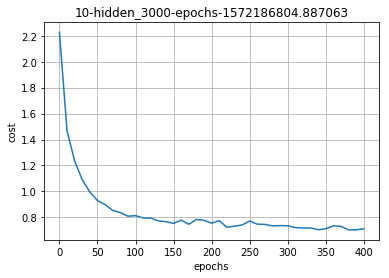

In [15]:
# Add weight decay
np.random.seed(40)

def train():
    plotter = Plotter("10-hidden_3000-epochs-{}".format(time.time()))
    data, labels, one_hots, mean, std = load_data()
    data_size = data.shape[0]
    lr = 0.05
    w_decay = 0.01
    no_hidden = 40
    
    
    W1, W2 = np.random.rand(no_hidden, 3072) * 0.0001, np.random.rand(10, no_hidden) * 0.0001
    b1, b2 = np.zeros((no_hidden, 1)), np.zeros((10, 1))
    
    batch_size = 100
    iterations = data_size // batch_size
    
    start_t = time.time()

    for epoch in range(401):
        avg_loss = 0
        accuracy = 0
        
        for idx in range(iterations):
            start = batch_size * idx
            end = batch_size * (idx + 1)

            x = data[start:end,:].T # 3072x100
            one_hot = one_hots[start:end,:] # 100x10

            # forward
            Z1 = np.dot(W1, x) + b1
            A1 = ReLU(Z1) # 10x100

            Z2 = np.dot(W2, A1) + b2
            A2 = softmax(Z2) # 10x100

            # log loss
            L2 = np.sum(W1 ** 2) + np.sum(W2 ** 2)
            loss = -np.sum(one_hot * np.log(1e-15 + A2.T)) + w_decay * L2
            
            avg_loss += (loss / batch_size)
            accuracy += check_if_correct(one_hot, A2)

            # backward
            dZ2 = A2 - one_hot.T # 10x100

            dW2 = np.dot(dZ2, A1.T) / batch_size # 10x10
            dW2 += w_decay * W2
            db2 = np.sum(dZ2, axis=1).reshape(-1,1) / batch_size # 10x1

            dA1 = np.dot(W2.T, dZ2)
            dZ1 = dA1 * dReLU(Z1)

            dW1 = np.dot(dZ1, x.T) / batch_size # 10x3072
            dW1 += w_decay * W1
            db1 = np.sum(dZ1, axis=1).reshape(-1,1) / batch_size # 10x1

            # update
            W1 = W1 - lr * dW1
            b1 = b1 - lr * db1
            W2 = W2 - lr * dW2
            b2 = b2 - lr * db2

        avg_loss /= iterations
        accuracy /= iterations
    
        if (epoch % 10 == 0):
            plotter.add(epoch, avg_loss)
            print("epoch: {} \tloss: {:.3} \tacc: {:.3}".format(epoch, avg_loss, accuracy))

    print("{:.3} s".format(time.time() - start_t))
    plotter.plot()

train()